In [2]:
# see http://icsdweb.aegean.gr/awid for more info

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


2022-06-27 21:46:24.229409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 21:46:24.229466: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# helper funcs
def class_distribution_bar(series, title):
    series['class'].value_counts(normalize=True).plot(kind="bar")

    plt.gcf()
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    
def correlated_features(corr):
    sorted_mat = corr.unstack().sort_values().dropna()

    visited = []
    to_drop = []

    print(f"{'Feature 1':30} {'Feature 2':30} {'Correlation':10}")
    for i, x in sorted_mat.items():
        if x < 0.95:
            continue
        if i[0] == i[1]:
            continue
        if ( (i[0], i[1]) in visited ) or ( (i[1], i[0]) in visited ):
            continue
        visited.append((i[0], i[1]))
        print(f"{i[0]:30} {i[1]:30} {x:02}")
        to_drop.append(i[1])
    return to_drop
# simple function to test the accuracy of a model fitted on training data on our testing data
def get_test_accuracy_of(model):
    y_preds = model.predict(X_test)
    return accuracy_score(y_preds, y_test)

In [3]:
# http://icsdweb.aegean.gr/awid/features.html

# get the names of the features
    
features = ['frame.interface_id',
 'frame.dlt',
 'frame.offset_shift',
 'frame.time_epoch',
 'frame.time_delta',
 'frame.time_delta_displayed',
 'frame.time_relative',
 'frame.len',
 'frame.cap_len',
 'frame.marked',
 'frame.ignored',
 'radiotap.version',
 'radiotap.pad',
 'radiotap.length',
 'radiotap.present.tsft',
 'radiotap.present.flags',
 'radiotap.present.rate',
 'radiotap.present.channel',
 'radiotap.present.fhss',
 'radiotap.present.dbm_antsignal',
 'radiotap.present.dbm_antnoise',
 'radiotap.present.lock_quality',
 'radiotap.present.tx_attenuation',
 'radiotap.present.db_tx_attenuation',
 'radiotap.present.dbm_tx_power',
 'radiotap.present.antenna',
 'radiotap.present.db_antsignal',
 'radiotap.present.db_antnoise',
 'radiotap.present.rxflags',
 'radiotap.present.xchannel',
 'radiotap.present.mcs',
 'radiotap.present.ampdu',
 'radiotap.present.vht',
 'radiotap.present.reserved',
 'radiotap.present.rtap_ns',
 'radiotap.present.vendor_ns',
 'radiotap.present.ext',
 'radiotap.mactime',
 'radiotap.flags.cfp',
 'radiotap.flags.preamble',
 'radiotap.flags.wep',
 'radiotap.flags.frag',
 'radiotap.flags.fcs',
 'radiotap.flags.datapad',
 'radiotap.flags.badfcs',
 'radiotap.flags.shortgi',
 'radiotap.datarate',
 'radiotap.channel.freq',
 'radiotap.channel.type.turbo',
 'radiotap.channel.type.cck',
 'radiotap.channel.type.ofdm',
 'radiotap.channel.type.2ghz',
 'radiotap.channel.type.5ghz',
 'radiotap.channel.type.passive',
 'radiotap.channel.type.dynamic',
 'radiotap.channel.type.gfsk',
 'radiotap.channel.type.gsm',
 'radiotap.channel.type.sturbo',
 'radiotap.channel.type.half',
 'radiotap.channel.type.quarter',
 'radiotap.dbm_antsignal',
 'radiotap.antenna',
 'radiotap.rxflags.badplcp',
 'wlan.fc.type_subtype',
 'wlan.fc.version',
 'wlan.fc.type',
 'wlan.fc.subtype',
 'wlan.fc.ds',
 'wlan.fc.frag',
 'wlan.fc.retry',
 'wlan.fc.pwrmgt',
 'wlan.fc.moredata',
 'wlan.fc.protected',
 'wlan.fc.order',
 'wlan.duration',
 'wlan.ra',
 'wlan.da',
 'wlan.ta',
 'wlan.sa',
 'wlan.bssid',
 'wlan.frag',
 'wlan.seq',
 'wlan.bar.type',
 'wlan.ba.control.ackpolicy',
 'wlan.ba.control.multitid',
 'wlan.ba.control.cbitmap',
 'wlan.bar.compressed.tidinfo',
 'wlan.ba.bm',
 'wlan.fcs_good',
 'wlan_mgt.fixed.capabilities.ess',
 'wlan_mgt.fixed.capabilities.ibss',
 'wlan_mgt.fixed.capabilities.cfpoll.ap',
 'wlan_mgt.fixed.capabilities.privacy',
 'wlan_mgt.fixed.capabilities.preamble',
 'wlan_mgt.fixed.capabilities.pbcc',
 'wlan_mgt.fixed.capabilities.agility',
 'wlan_mgt.fixed.capabilities.spec_man',
 'wlan_mgt.fixed.capabilities.short_slot_time',
 'wlan_mgt.fixed.capabilities.apsd',
 'wlan_mgt.fixed.capabilities.radio_measurement',
 'wlan_mgt.fixed.capabilities.dsss_ofdm',
 'wlan_mgt.fixed.capabilities.del_blk_ack',
 'wlan_mgt.fixed.capabilities.imm_blk_ack',
 'wlan_mgt.fixed.listen_ival',
 'wlan_mgt.fixed.current_ap',
 'wlan_mgt.fixed.status_code',
 'wlan_mgt.fixed.timestamp',
 'wlan_mgt.fixed.beacon',
 'wlan_mgt.fixed.aid',
 'wlan_mgt.fixed.reason_code',
 'wlan_mgt.fixed.auth.alg',
 'wlan_mgt.fixed.auth_seq',
 'wlan_mgt.fixed.category_code',
 'wlan_mgt.fixed.htact',
 'wlan_mgt.fixed.chanwidth',
 'wlan_mgt.fixed.fragment',
 'wlan_mgt.fixed.sequence',
 'wlan_mgt.tagged.all',
 'wlan_mgt.ssid',
 'wlan_mgt.ds.current_channel',
 'wlan_mgt.tim.dtim_count',
 'wlan_mgt.tim.dtim_period',
 'wlan_mgt.tim.bmapctl.multicast',
 'wlan_mgt.tim.bmapctl.offset',
 'wlan_mgt.country_info.environment',
 'wlan_mgt.rsn.version',
 'wlan_mgt.rsn.gcs.type',
 'wlan_mgt.rsn.pcs.count',
 'wlan_mgt.rsn.akms.count',
 'wlan_mgt.rsn.akms.type',
 'wlan_mgt.rsn.capabilities.preauth',
 'wlan_mgt.rsn.capabilities.no_pairwise',
 'wlan_mgt.rsn.capabilities.ptksa_replay_counter',
 'wlan_mgt.rsn.capabilities.gtksa_replay_counter',
 'wlan_mgt.rsn.capabilities.mfpr',
 'wlan_mgt.rsn.capabilities.mfpc',
 'wlan_mgt.rsn.capabilities.peerkey',
 'wlan_mgt.tcprep.trsmt_pow',
 'wlan_mgt.tcprep.link_mrg',
 'wlan.wep.iv',
 'wlan.wep.key',
 'wlan.wep.icv',
 'wlan.tkip.extiv',
 'wlan.ccmp.extiv',
 'wlan.qos.tid',
 'wlan.qos.priority',
 'wlan.qos.eosp',
 'wlan.qos.ack',
 'wlan.qos.amsdupresent',
 'wlan.qos.buf_state_indicated',
 'wlan.qos.bit4',
 'wlan.qos.txop_dur_req',
 'wlan.qos.buf_state_indicated1',
 'data.len',
 'class']

In [4]:
# import a training set
awid = pd.read_csv("data/AWID-CLS-R-Trn.csv", header=None, names=features)

# see the number of rows/columns
awid.shape

/tmp/ipykernel_70258/3830310353.py:2: DtypeWarning: Columns (37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,74,88) have mixed types. Specify dtype option on import or set low_memory=False.
  awid = pd.read_csv("data/AWID-CLS-R-Trn.csv", header=None, names=features)


(1000000, 155)

In [5]:
# they use ? as a null attribute. We will eventually have to replace them with None values
awid.head(n=9)

,frame.interface_id,frame.dlt,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.len,frame.cap_len,frame.marked,...,wlan.qos.priority,wlan.qos.eosp,wlan.qos.ack,wlan.qos.amsdupresent,wlan.qos.buf_state_indicated,wlan.qos.bit4,wlan.qos.txop_dur_req,wlan.qos.buf_state_indicated1,data.len,class
0,0,?,0.0,1.393661e+09,0.024271,0.024271,0.024271,185,185,0,...,?,?,?,?,?,?,?,?,?,normal
1,0,?,0.0,1.393661e+09,0.055325,0.055325,0.081227,159,159,0,...,?,?,?,?,?,?,?,?,?,normal
2,0,?,0.0,1.393661e+09,0.000005,0.000005,0.081647,40,40,0,...,?,?,?,?,?,?,?,?,?,normal
3,0,?,0.0,1.393661e+09,0.000142,0.000142,0.098481,40,40,0,...,?,?,?,?,?,?,?,?,?,normal
4,0,?,0.0,1.393661e+09,0.001801,0.001801,0.128349,185,185,0,...,?,?,?,?,?,?,?,?,?,normal
5,0,?,0.0,1.393661e+09,0.000023,0.000023,0.140866,54,54,0,...,?,?,?,?,?,?,?,?,?,normal
6,0,?,0.0,1.393661e+09,0.042729,0.042729,0.183633,159,159,0,...,?,?,?,?,?,?,?,?,?,normal
7,0,?,0.0,1.393661e+09,0.006308,0.006308,0.215243,54,54,0,...,?,?,?,?,?,?,?,?,?,normal
8,0,?,0.0,1.393661e+09,0.002270,0.002270,0.217518,1524,1524,0,...,1,0,0x0000,0,?,?,?,0,1460,normal


In [6]:
# see the distribution of response vars
awid['class'].value_counts(normalize=True)

normal           0.837615
injection        0.065379
impersonation    0.048522
flooding         0.048484
Name: class, dtype: float64

In [7]:
# claims there are no null values because of the ?'s'
awid.isna().sum()

frame.interface_id               0
frame.dlt                        0
frame.offset_shift               0
frame.time_epoch                 0
frame.time_delta                 0
                                ..
wlan.qos.bit4                    0
wlan.qos.txop_dur_req            0
wlan.qos.buf_state_indicated1    0
data.len                         0
class                            0
Length: 155, dtype: int64

In [8]:
# replace the ? marks with None
awid.replace({"?": None}, inplace=True)

In [78]:
# Many missing pieces of data!
awid.isna().sum()

frame.interface_id                     0
frame.dlt                        1000000
frame.offset_shift                     0
frame.time_epoch                       0
frame.time_delta                       0
                                  ...   
wlan.qos.bit4                     924693
wlan.qos.txop_dur_req             924693
wlan.qos.buf_state_indicated1     737014
data.len                          473721
class                                  0
Length: 155, dtype: int64

In [9]:
# goal is to remove columns that have over 50% of missing data
columns_with_mostly_null_data = awid.columns[awid.isnull().mean() >= 0.4]
# 72 columns are going to be affected!
columns_with_mostly_null_data.shape

(72,)

In [10]:
# drop the columns with over half missing data
awid.drop(columns_with_mostly_null_data, axis=1, inplace=True)

In [81]:
awid.shape

(1000000, 83)

In [11]:
# now drop the rows that have missing values
awid.dropna(inplace=True)  # drop rows with null data

In [12]:
# lost 456,169 rows
awid.shape

(782934, 83)

In [13]:
# doesn't affect our distribution too much

# 0.878763  is our null accuracy. Our model must be better than this number to be a contender
awid['class'].value_counts(normalize=True)

normal           0.792594
injection        0.083505
impersonation    0.061975
flooding         0.061926
Name: class, dtype: float64

In [14]:
# only select numerical columns for our ML algorithms, there should be more..
awid.select_dtypes(['number']).shape

(782934, 45)

In [15]:
# transform all columns into numerical dtypes
for col in awid.columns:
    awid[col] = pd.to_numeric(awid[col], errors='ignore')

In [16]:
# that makes more sense
awid.select_dtypes(['number']).shape

(782934, 74)

In [17]:
# basic descroptive statistics
awid.describe()

,frame.interface_id,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.len,frame.cap_len,frame.marked,frame.ignored,...,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected,wlan.fc.order,wlan.duration,wlan.frag,wlan.seq,wlan.fcs_good
count,782934.0,782934.0,7.829340e+05,782934.000000,782934.000000,782934.000000,782934.000000,782934.000000,782934.0,782934.0,...,782934.000000,782934.000000,782934.000000,782934.000000,782934.000000,782934.0,782934.000000,782934.000000,782934.000000,782934.0
mean,0.0,0.0,1.393663e+09,0.002467,0.002467,1947.650029,620.717656,620.717656,0.0,0.0,...,0.000860,0.156058,0.046098,0.002107,0.668551,0.0,107.535691,0.003705,1857.879482,1.0
std,0.0,0.0,8.655622e+02,0.006741,0.006741,865.562233,688.260926,688.260926,0.0,0.0,...,0.029306,0.362910,0.209698,0.045859,0.470735,0.0,127.759776,0.153893,1204.214008,0.0
min,0.0,0.0,1.393661e+09,0.000001,0.000001,0.024271,54.000000,54.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
25%,0.0,0.0,1.393663e+09,0.000467,0.000467,1385.202560,98.000000,98.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,44.000000,0.000000,759.000000,1.0
50%,0.0,0.0,1.393663e+09,0.000805,0.000805,1949.666097,124.000000,124.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,44.000000,0.000000,1703.000000,1.0
75%,0.0,0.0,1.393664e+09,0.001444,0.001444,2766.098201,1552.000000,1552.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,314.000000,0.000000,2886.000000,1.0
max,0.0,0.0,1.393665e+09,0.350263,0.350263,3599.571287,1570.000000,1570.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,320.000000,12.000000,4095.000000,1.0


Feature 1                      Feature 2                      Correlation


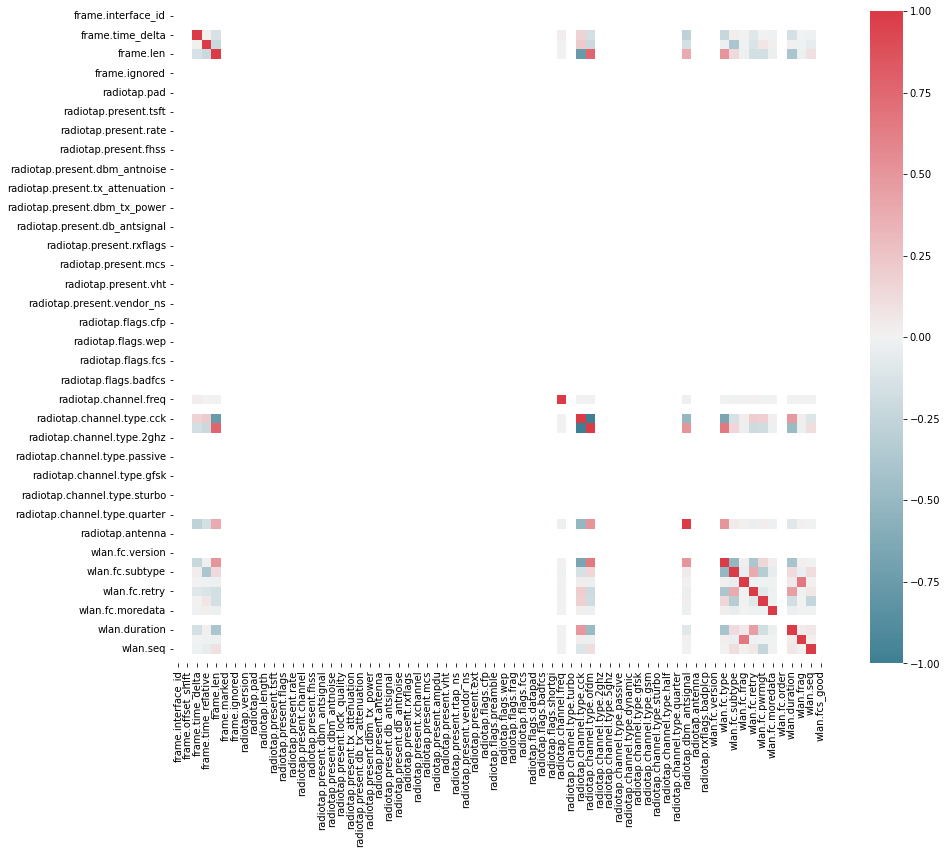

In [19]:
# run correlation matrix and plot
f, ax = plt.subplots(figsize=(16, 12))
corr = awid.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

features_corr = correlated_features(corr)

Before drop:
(782934, 77)


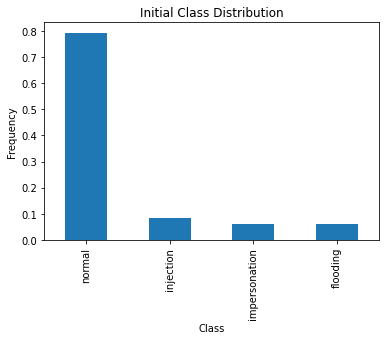

In [20]:
print("Before drop:")
print(awid.shape)

features_to_drop = ["frame.cap_len", "frame.time_delta_displayed", "frame.time_epoch", "radiotap.mactime", "radiotap.datarate", "wlan.fc.protected"]

awid.drop(features_to_drop, inplace=True, axis=1)

print("After drop:")
print(awid.shape)

class_distribution_bar(awid, "Initial Class Distribution")

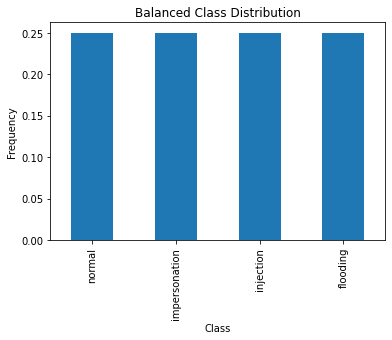

In [21]:


df = awid.sample(frac=1)


inj = df[df['class'] == 'injection']
impers = df[df['class'] == 'impersonation']
flooding = df[df['class'] == 'flooding']
normal = df[df['class'] == 'normal']


samples = min(len(inj), len(impers), len(flooding))

awid = pd.concat([inj.sample(n=samples), impers.sample(n=samples), flooding.sample(n=samples), normal.sample(n=samples)])
awid = awid.sample(frac=1).reset_index()
awid['class'].value_counts(normalize=True)

class_distribution_bar(awid, "Balanced Class Distribution")

In [23]:
print(awid.shape)
X, y = awid.select_dtypes(['number']), awid['class']

(193936, 78)


In [ ]:
# do a basic naive bayes fitting
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

# fit our model to the data
nb.fit(X, y)

In [ ]:
# basic metric, accuracy
from sklearn.metrics import accuracy_score

In [ ]:
# simple function to test the accuracy of a model fitted on training data on our testing data
def get_test_accuracy_of(model):
    y_preds = model.predict(X_test)
    return accuracy_score(y_preds, y_test)
    
get_test_accuracy_of(nb)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X, y)

get_test_accuracy_of(lr)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(X, y)

get_test_accuracy_of(tree)

In [ ]:
# see gini scores of decision tree features
pd.DataFrame({'feature':awid.select_dtypes(['number']).columns, 
              'importance':tree.feature_importances_}).sort_values('importance', ascending=False).head(10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest.fit(X, y)

get_test_accuracy_of(forest)

In [ ]:
# Create a pipeline that will scale the numerical data and then feed the resulting data into a decision tree

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

preprocessing = Pipeline([
    ("scale", StandardScaler()),
])

pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", DecisionTreeClassifier())
])

# try varying levels of depth
params = {
    "classifier__max_depth": [None, 3, 5, 10], 
         }

# instantiate a gridsearch module
grid = GridSearchCV(pipeline, params)
# fit the module
grid.fit(X, y)

# test the best model
get_test_accuracy_of(grid.best_estimator_)

In [ ]:
# try the same thing with a random forest

preprocessing = Pipeline([
    ("scale", StandardScaler()),
])

pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", RandomForestClassifier())
])

# try varying levels of depth
params = {
    "classifier__max_depth": [None, 3, 5, 10], 
         }

grid = GridSearchCV(pipeline, params)
grid.fit(X, y)
# best accuracy so far!
get_test_accuracy_of(grid.best_estimator_)

# Deep Learning Implementation

In [47]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [123]:
def train_predict_and_save_model(model, model_name, X_train, y_train, X_test, y_test, epochs = 10, batch_size=32):
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    
    y_hat = model.predict(X_test)
    #Get Prediction
    new_y_hat=[]
    for i in y_hat:
        greater = i[0]
        last = i[0]
        for j in range(1,4):
            if i[j] > last:
                greater = j
                last = i[j]
        new_y_hat.append(greater)

    y_hat = new_y_hat
    
    print(f"\nAccuracy:{accuracy_score(y_test, y_hat)}")
    
    model.save(model_name)

In [27]:
epochs = 10

# Sequential Model

In [30]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=(len(X_train.columns))))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=4, activation='sigmoid'))
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss_fn, optimizer='adam', metrics='accuracy')

train_predict_and_save_model(model, "SequentialModel", X_train, y_train, X_test, y_test, 2, batch_size = 32)

Epoch 1/10
19574/19574 [==============================] - 17s 862us/step - loss: 0.5220 - accuracy: 0.9525
Epoch 2/10
19574/19574 [==============================] - 17s 893us/step - loss: 0.0342 - accuracy: 0.9909
Epoch 3/10
19574/19574 [==============================] - 17s 891us/step - loss: 0.0216 - accuracy: 0.9939
Epoch 4/10
19574/19574 [==============================] - 17s 874us/step - loss: 0.0178 - accuracy: 0.9949
Epoch 5/10
19574/19574 [==============================] - 16s 836us/step - loss: 0.0163 - accuracy: 0.9953
Epoch 6/10
19574/19574 [==============================] - 17s 871us/step - loss: 0.0151 - accuracy: 0.9958
Epoch 7/10
19574/19574 [==============================] - 17s 865us/step - loss: 0.0143 - accuracy: 0.9961
Epoch 8/10
19574/19574 [==============================] - 18s 907us/step - loss: 0.0140 - accuracy: 0.9962
Epoch 9/10
19574/19574 [==============================] - 18s 903us/step - loss: 0.0138 - accuracy: 0.9962
Epoch 10/10
4894/4894 [==============

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

# ... Model

In [31]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=(len(X_train.columns))))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=4, activation='sigmoid'))

model.compile(loss="mean_squared_error", optimizer="sgd", metrics='accuracy')   

train_predict_and_save_model(model, "SequentialActLinearModel", X_train, y_train, X_test, y_test, epochs, batch_size = 128)

Epoch 1/10
19574/19574 [==============================] - 17s 873us/step - loss: 4.2984 - accuracy: 0.0619
Epoch 2/10
19574/19574 [==============================] - 18s 911us/step - loss: 4.3692 - accuracy: 0.0619
Epoch 3/10
19574/19574 [==============================] - 18s 912us/step - loss: 4.3692 - accuracy: 0.0619
Epoch 4/10
19574/19574 [==============================] - 18s 924us/step - loss: 4.3692 - accuracy: 0.0619
Epoch 5/10
19574/19574 [==============================] - 17s 871us/step - loss: 4.3692 - accuracy: 0.0619
Epoch 6/10
19574/19574 [==============================] - 17s 857us/step - loss: 4.3692 - accuracy: 0.0619
Epoch 7/10
 1769/19574 [=>............................] - ETA: 15s - loss: 4.3586 - accuracy: 0.0618

KeyboardInterrupt: 

In [ ]:
#Save model on file
model.save(model_name)

In [ ]:
del model

In [ ]:
#load model from file
model = load_model('SequentialTFModel')

In [ ]:
# Correlation Matrix
import matplotlib.pyplot as plt
import seaborn as sns


f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = awid.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()